# Интерпретация. Практическая работа

## Цель практической работы

Научиться интерпретировать модели кластеризации.

## Что входит в практическую работу


1. Загрузить данные и провести разведочный анализ.
2. Предположить оптимальное количество кластеров.
3. Очистить и подготовить данные для использования в моделях машинного обучения.
4. Построить модель кластеризации с помощью библиотеки Scikit-learn и вычислить оптимальное количество кластеров.
5. Визуализировать результаты кластеризации.
6. Интерпретировать полученные результаты.
7. Подкрепить выводы интерпретации визуализациями.

## Что оценивается 

* Выполнены все этапы работы.
* Сделаны выводы по результатам разведочного анализа данных.
* Выполнена и обоснована подготовка данных.
* Выбор количества кластеров обоснован и подкреплён визуализацией. 
* Выбор гиперпараметров метода понижения размерности обоснован.
* Интерпретация кластеров подкреплена расчётами и визуализацией. 



# Задача

У вас имеется некоторый набор данных `marketing_campaign.csv` о покупателях супермаркета.

* ID — уникальный идентификатор клиента.
* Year_Birth — год рождения клиента.
* Dt_Customer — дата регистрации клиента на сайте.
* Recency — количество дней с момента последней покупки клиента.
* MntFruits — сумма, потраченная на фрукты за последние два года.
* MntMeatProducts — сумма, потраченная на мясо за последние два года.
* MntFishProducts — сумма, потраченная на рыбу за последние два года.
* MntSweetProducts — сумма, потраченная на сладости за последние два года.
* NumWebPurchases — количество покупок, совершённых через сайт.
* NumStorePurchases — количество покупок, совершённых непосредственно в магазинах.
* Response: 1, если клиент участвовал в последней рекламной кампании, 0 — в противном случае.

Решите задачу кластеризации покупателей, чтобы в дальнейшем планировать маркетинговые акции для каждой группы покупателей. Подготовьте результаты своей работы для демонстрации заказчику, не погружённому в машинное обучение.

In [208]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [209]:
import EDAFunctions

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import pandas as pd
import hdbscan
from ydata_profiling import ProfileReport
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.decomposition import PCA


warnings.filterwarnings('ignore')

# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

In [210]:
df = pd.read_csv("marketing campaign.csv")
df.Dt_Customer = pd.to_datetime(df.Dt_Customer, format="%d-%m-%Y")
df = df.rename(columns={"Response": "target", "Dt_Customer": 'Date'})
df.head()

,ID,Year_Birth,Date,Recency,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,NumWebPurchases,NumStorePurchases,target
0,5524,1957,2012-09-04,58,88,546,172,88,8,4,1
1,2174,1954,2014-03-08,38,1,6,2,1,1,2,0
2,4141,1965,2013-08-21,26,49,127,111,21,8,10,0
3,6182,1984,2014-02-10,26,4,20,10,3,2,4,0
4,5324,1981,2014-01-19,94,43,118,46,27,5,6,0


In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 2240 non-null   int64         
 1   Year_Birth         2240 non-null   int64         
 2   Date               2240 non-null   datetime64[ns]
 3   Recency            2240 non-null   int64         
 4   MntFruits          2240 non-null   int64         
 5   MntMeatProducts    2240 non-null   int64         
 6   MntFishProducts    2240 non-null   int64         
 7   MntSweetProducts   2240 non-null   int64         
 8   NumWebPurchases    2240 non-null   int64         
 9   NumStorePurchases  2240 non-null   int64         
 10  target             2240 non-null   int64         
dtypes: datetime64[ns](1), int64(10)
memory usage: 192.6 KB


In [212]:
df.target.value_counts()

target
0    1906
1     334
Name: count, dtype: int64

In [213]:
# report = ProfileReport(df)
# report.to_notebook_iframe()

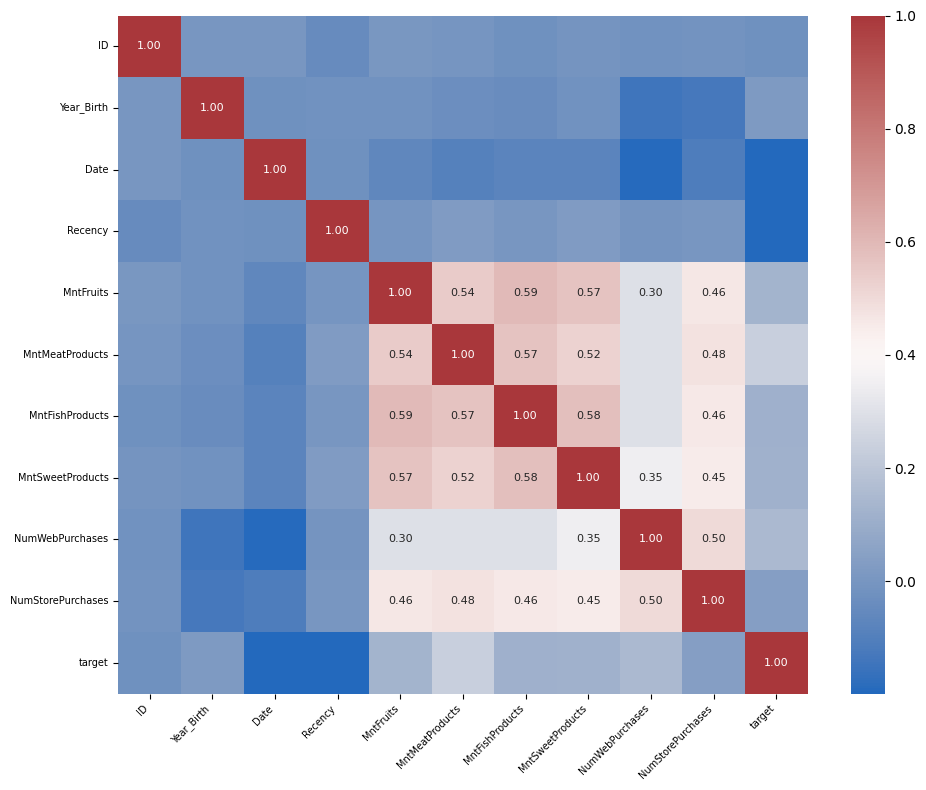

In [214]:
EDAFunctions.show_correlation_heatmap(df)

In [215]:
# EDAFunctions.show_pair_plot(df)

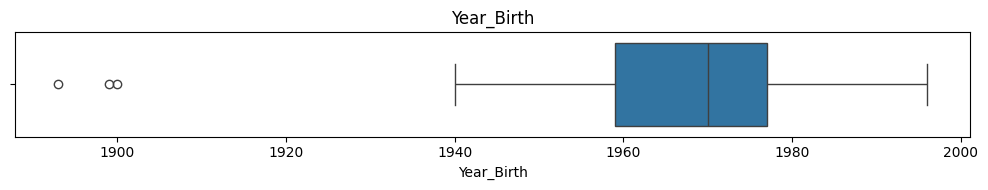

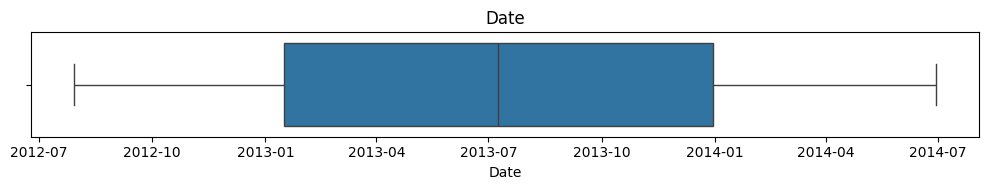

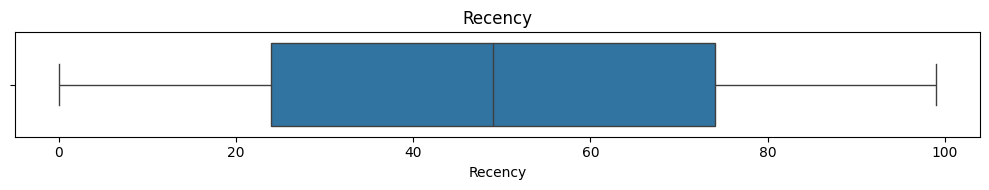

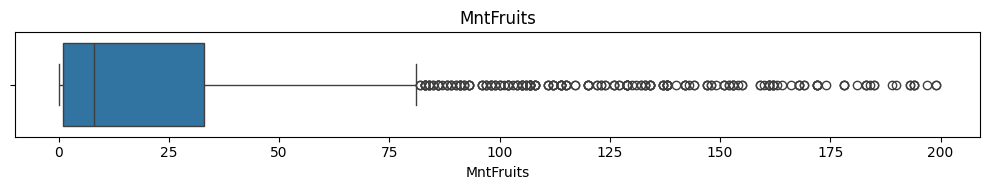

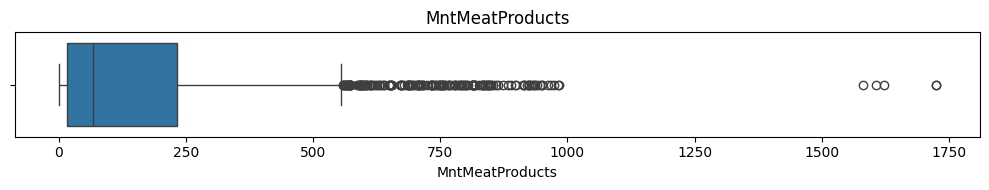

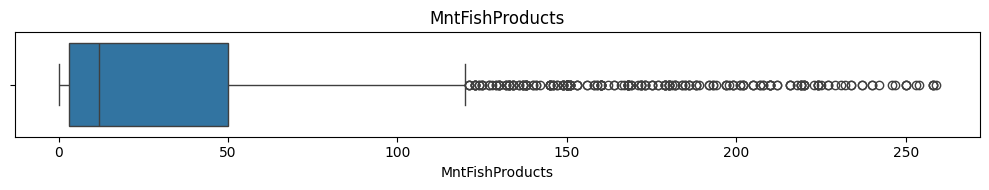

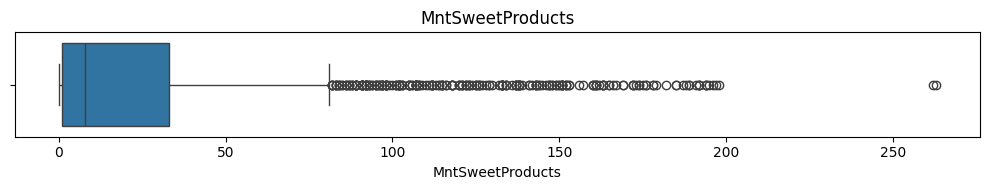

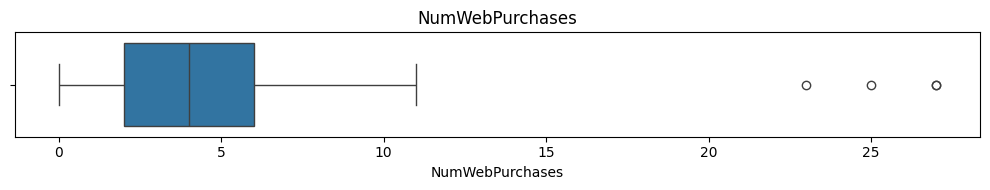

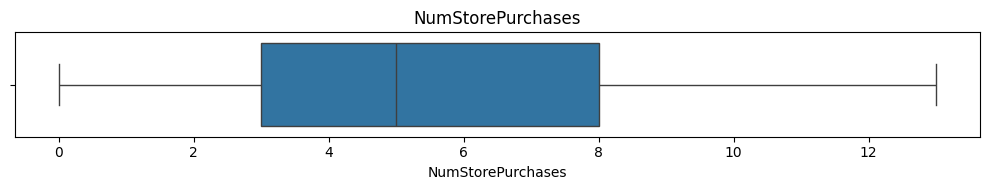

In [216]:
features = df.columns[1:-1]
EDAFunctions.show_box_plot(df, features)

**Только построив боксплоты, я понял, что нам показывает диагональ на pairplot'e.**

# Задание 2

Метод k-средних требует явно задать количество кластеров, на которые будут разбиваться данные. Данных может быть так много, что построение одной модели будет занимать несколько часов, поэтому важно заранее примерно представлять количество кластеров до запуска обучения модели.

На основе проведённого разведочного анализа данных предположите, какое количество кластеров будет оптимальным, аргументируйте своё предположение.

**Лично я вообще ничего на графиках не увидел. Наверное, будет три.**


# Задание 3

Выполните очистку и подготовку данных для дальнейшего использования при построении моделей машинного обучения. Аргументируйте выбранные шаги подготовки данных. 

**Подрежем выбросы и аномалии**

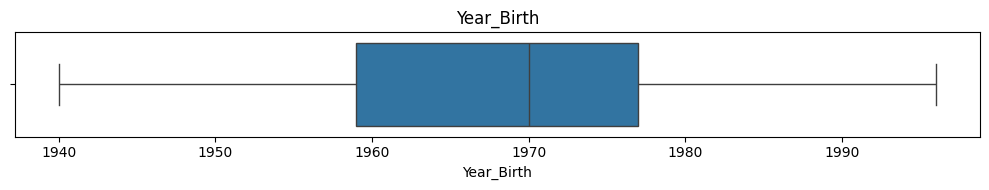

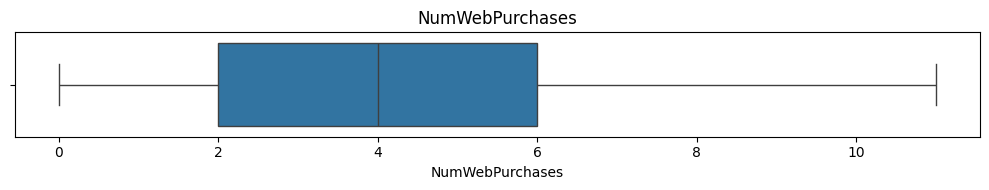

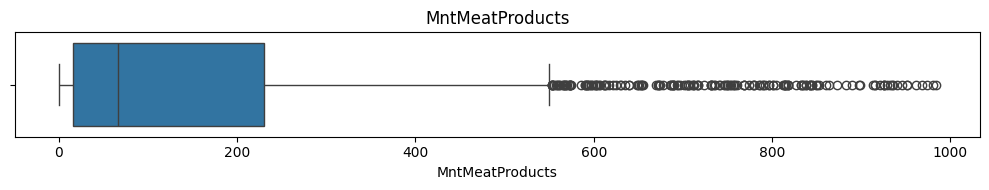

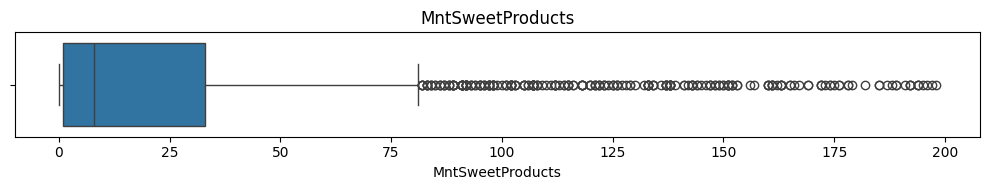

In [217]:
df.loc[df["Year_Birth"] < 1940, "Year_Birth"] = df["Year_Birth"].median()
df.loc[df["NumWebPurchases"] > 15, "NumWebPurchases"] = df["NumWebPurchases"].median()
df.loc[df["MntMeatProducts"] > 1250, "MntMeatProducts"] = df["MntMeatProducts"].median()
df.loc[df["MntSweetProducts"] > 200, "MntSweetProducts"] = df["MntSweetProducts"].median()

features = ["Year_Birth", "NumWebPurchases", "MntMeatProducts", "MntSweetProducts"]

EDAFunctions.show_box_plot(df, features)

# Задание 4

Постройте модель кластеризации с помощью метода k-средних. Определите оптимальное количество кластеров с помощью метода локтя и метрики silhouette score. 

Помните, что аналитический способ определения количества кластеров не является единственно верным. Если ваше понимание предметной области и результаты анализа данных расходятся с результатами метода локтя, вы можете выбрать и обосновать количество кластеров, исходя из своего опыта.

In [218]:
df_k = df.copy().drop(columns=["Date", "ID"])
for i, name in enumerate(df_k.columns):
    X = df_k.iloc[:, [i, -1]].values
    EDAFunctions.get_best_k(X, name)

Best score for Year_Birth          : 0.6, k = 2
Best score for Recency             : 0.62, k = 2
Best score for MntFruits           : 0.78, k = 2
Best score for MntMeatProducts     : 0.75, k = 2
Best score for MntFishProducts     : 0.77, k = 2
Best score for MntSweetProducts    : 0.78, k = 2
Best score for NumWebPurchases     : 0.86, k = 14
Best score for NumStorePurchases   : 0.79, k = 14
Best score for target              : 1.0, k = 2


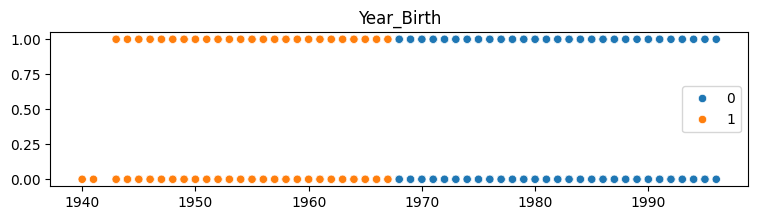

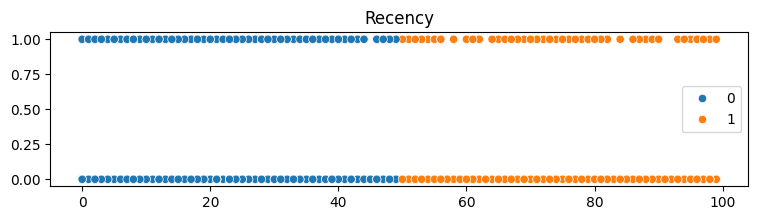

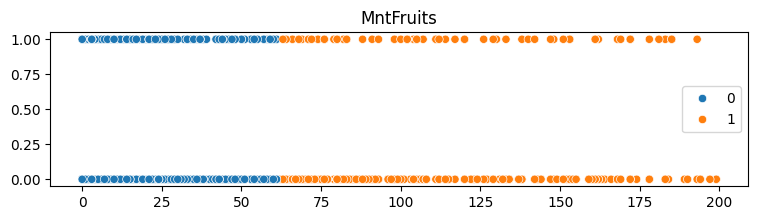

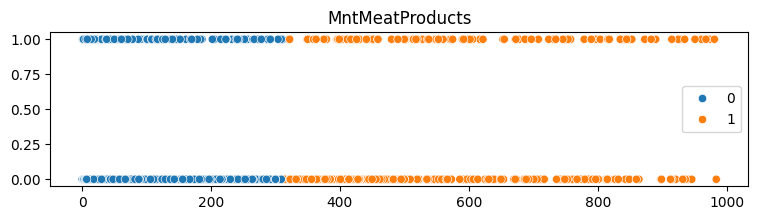

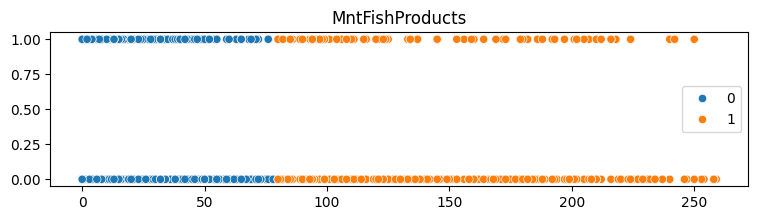

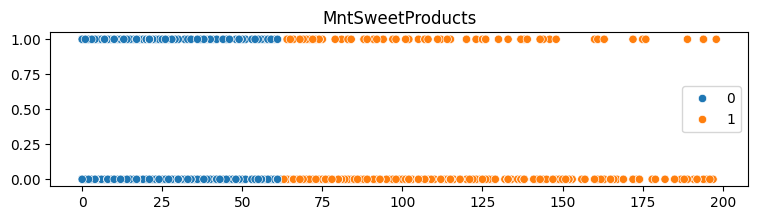

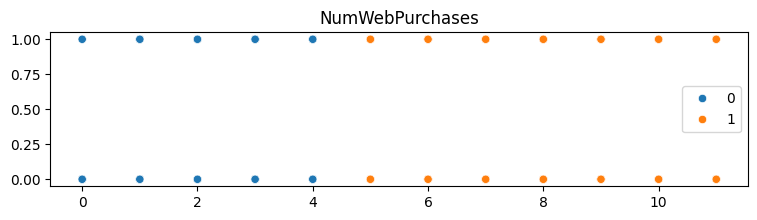

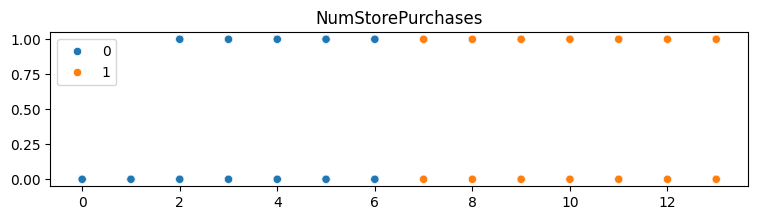

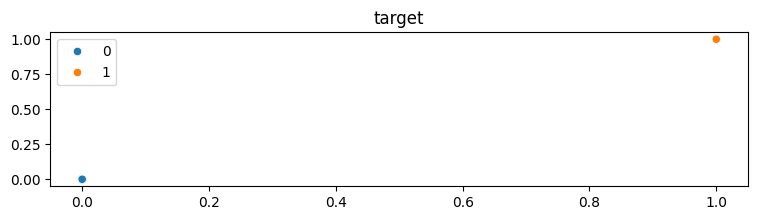

In [244]:
df_k1 = df.copy().drop(columns=["Date", "ID"])
for i, name in enumerate(df_k.columns):
    X = df_k1.iloc[:, [i, -1]].values
    km = KMeans(n_clusters=2, random_state=42)
    km.fit(X)
    plt.figure(figsize=(9, 2))
    clusters = km.predict(X)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=clusters).set_title(f"{name}")
plt.show();

**Ничего не понятно**

# Задание 5

Визуализируйте результаты кластеризации на двумерном графике с помощью метода t-SNE. Обоснуйте выбранные значения его гиперпараметров.

In [220]:
df_cl = df.copy().drop(columns=["Date", "ID"])

### **5.1. Пробуем метод отбора**

In [221]:
from sklearn.feature_selection import SelectKBest, chi2

# Пример данных
X = df_cl.drop(columns=["target"])
y = df.target

# Выбор лучших признаков
selector = SelectKBest(score_func=chi2, k=2)
X_new = pd.DataFrame(selector.fit_transform(X, y))

best_features = X.columns[selector.get_support()].to_list()
print(f"Лучшие признаки:\t{best_features}")
X_new

Лучшие признаки:	['MntMeatProducts', 'MntFishProducts']


,0,1
0,546,172
1,6,2
2,127,111
3,20,10
4,118,46
...,...,...
2235,182,42
2236,30,0
2237,217,32
2238,214,80


In [222]:
km = KMeans(n_clusters=2, random_state=137)
km.fit(df_cl)
labels_km = km.labels_

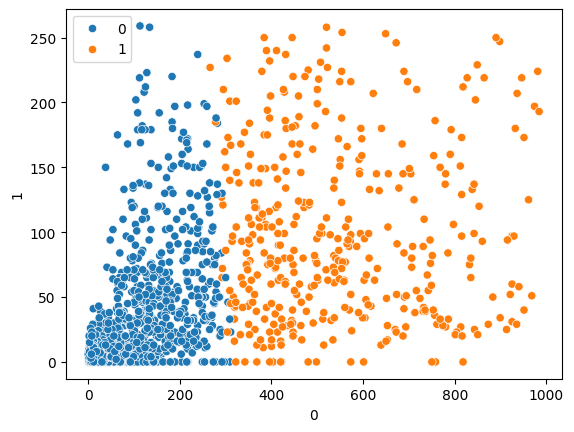

In [223]:
sns.scatterplot(data=X_new, x=0, y=1, hue=labels_km);

### **5.2. Собственно, сам t-SNE**

In [224]:
tsne = TSNE(n_components=2, perplexity=100, random_state=137)
X_tsne = pd.DataFrame(tsne.fit_transform(df_cl))
X_tsne

,0,1
0,37.308083,-1.861941
1,-26.960804,-11.117682
2,13.803004,-6.492085
3,-19.593044,-8.104741
4,8.267776,1.069936
...,...,...
2235,12.949339,-2.646635
2236,-15.875885,1.750926
2237,17.472281,6.353848
2238,17.249695,1.595582


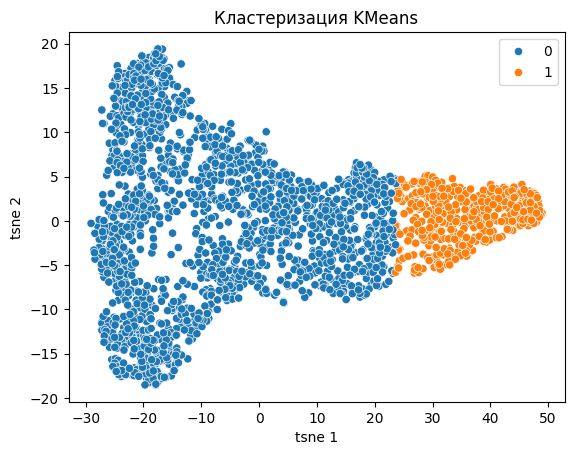

In [225]:
sns.scatterplot(data=X_tsne, x=0, y=1, hue=labels_km)
plt.xlabel("tsne 1")
plt.ylabel("tsne 2")
plt.title("Кластеризация KMeans")
plt.show;

In [226]:
print(f"Silhoutte score: {silhouette_score(X_tsne, labels_km)}")

Silhoutte score: 0.49279358983039856


### **5.3. HDBSCAN**

In [227]:
clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=220)
labels_hdbscan = clusterer.fit_predict(X_tsne)


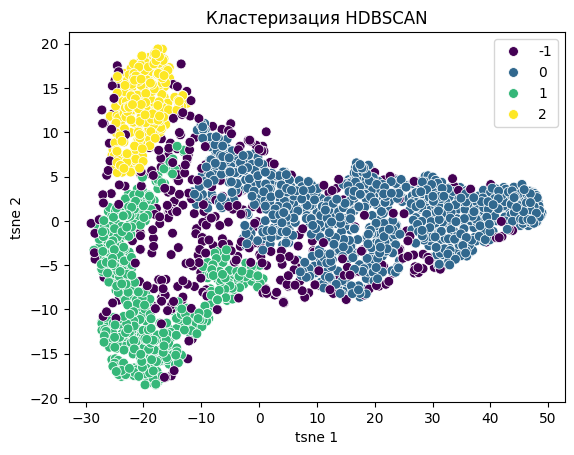

In [228]:
# Визуализация кластеров
sns.scatterplot(data=X_tsne, x=0, y=1, hue=labels_hdbscan, palette="viridis", s=50)
plt.xlabel("tsne 1")
plt.ylabel("tsne 2")
plt.title("Кластеризация HDBSCAN")
plt.show()

In [229]:
# Вывод информации о кластерах
n_clusters = len(np.unique(labels_hdbscan[labels_hdbscan != -1]))
n_noise = np.sum(labels_hdbscan == -1)
print(
    f"Количество кластеров: {n_clusters}\n"
    f"Количество шумовых точек: {n_noise}\n"
    f"Стабильность кластеров:{clusterer.cluster_persistence_}\n"
    f"Silhoutte score: {silhouette_score(X_tsne, labels_hdbscan):.2f}"
)

Количество кластеров: 3
Количество шумовых точек: 384
Стабильность кластеров:[0.0700744  0.12320096 0.12516101]
Silhoutte score: 0.24


**Попробуем найти лучшие параметры по силуэтному коэффициенту**

In [230]:
best_score = -1
best_params = {}

for min_cluster_size in range(100, 300, 10):
    for min_samples in range(5, 15, 1):
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size, min_samples=min_samples
        )
        labels = clusterer.fit_predict(X_tsne)

        # Оценка кластеров (игнорируем шум)
        if len(set(labels)) > 1:  # Проверяем, что есть хотя бы 2 кластера
            score = silhouette_score(X_tsne, labels)
            if score > best_score:
                best_score = score
                best_params = {
                    "min_cluster_size": min_cluster_size,
                    "min_samples": min_samples,
                }

print("Лучшие параметры:", best_params)
print("Лучший силуэтный коэффициент:", best_score)

Лучшие параметры: {'min_cluster_size': 190, 'min_samples': 5}
Лучший силуэтный коэффициент: 0.27485


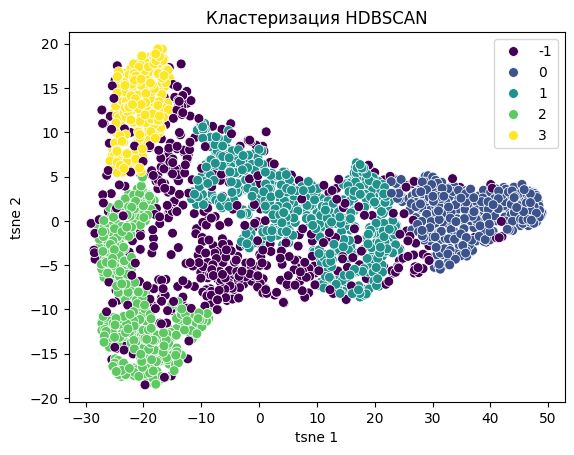

In [231]:
clusterer = hdbscan.HDBSCAN(
    min_samples=best_params["min_samples"],
    min_cluster_size=best_params["min_cluster_size"],
)
labels_hdbscan = clusterer.fit_predict(X_tsne)

# Визуализация кластеров
sns.scatterplot(data=X_tsne, x=0, y=1, hue=labels_hdbscan, palette="viridis", s=50)
plt.xlabel("tsne 1")
plt.ylabel("tsne 2")
plt.title("Кластеризация HDBSCAN")
plt.show()

**Ну, не. Руками подобранные параметры с 3 кластерами выглядят более правдобно.**

**Здесь ещё отмечу, что я также опробовал метод РСА + HDBSCAN, но их сочетание показало результат хуже, чем у t-SNE, а потом РСА вообще где-то потерялся. :)**

# Задание 6

Постройте профили кластеров и опишите их.

**Возьмём метки кластеров из km, т.к. у него и скор повыше, да и выглядит разделение более правдоподобно:**

In [ ]:
df_cl['cluster'] = labels_km

In [246]:
df_g = df_cl.groupby('cluster').agg(['mean', 'std']).T
df_g

cluster                           0            1
Year_Birth        mean  1968.949861  1968.714607
                  std     11.266298    13.293190
Recency           mean    48.868524    50.080899
                  std     28.790433    29.659292
MntFruits         mean    15.971588    67.973034
                  std     28.477764    50.286111
MntMeatProducts   mean    70.412813   538.541573
                  std     76.196919   180.607748
MntFishProducts   mean    22.335933    98.795506
                  std     38.308657    66.516109
MntSweetProducts  mean    16.582730    68.193258
                  std     30.108818    50.426188
NumWebPurchases   mean     3.759331     5.204494
                  std      2.637525     2.233241
NumStorePurchases mean     5.148747     8.377528
                  std      3.044201     2.734735
target            mean     0.113092     0.294382
                  std      0.316793     0.456277

# Задание 7

Визуализируйте профили кластеров. Подготовьте краткое резюме результатов вашего исследования для заказчика.

**Электронный болван подсказал, как красиво визуализировать полученные данные. По-моему, у него гораздо круче, чем у лектора.** 

**Пришлось отрезать возраст (им всё равно можно пренебречь), чтобы остальные признаки нормально отобразились.**

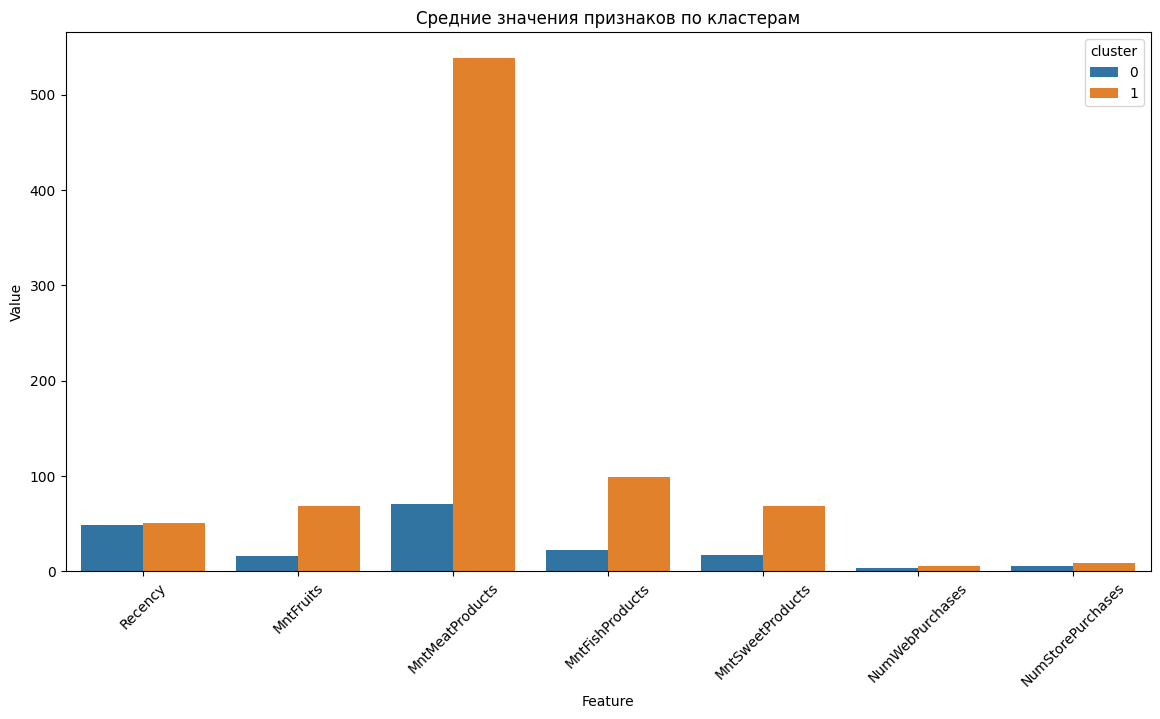

In [252]:

# Преобразуем данные для визуализации
cluster_summary = df_cl.drop(columns=['Year_Birth', 'target']).groupby("cluster").mean().reset_index()
cluster_summary = cluster_summary.melt(id_vars="cluster", var_name="Feature", value_name="Value")

# Построение графиков
plt.figure(figsize=(14, 7))
sns.barplot(data=cluster_summary, x="Feature", y="Value", hue="cluster")
plt.xticks(rotation=45)
plt.title("Средние значения признаков по кластерам")
plt.show()


Проанализируем данные и выделим ключевые различия между двумя кластерами:

---

### **1. Год рождения (`Year_Birth`)**
- **Средний год рождения (mean):** Оба кластера почти идентичны (1968.95 и 1968.71), что говорит о схожем среднем возрасте клиентов (~55 лет).
- **Стандартное отклонение (std):** Кластер 1 немного более разнообразен по возрасту (13.29 против 11.27).

**Вывод:** Возраст клиентов в кластерах почти не различается.

---

### **2. Время с момента последней покупки (`Recency`)**
- **Среднее (mean):** Значения близки: 48.87 для кластера 0 и 50.08 для кластера 1. Это указывает на то, что в среднем клиенты обоих кластеров покупали не так давно (~50 дней назад).
- **Стандартное отклонение (std):** Оба кластера имеют схожее разбросанное поведение.

**Вывод:** Поведение по "давности последней покупки" у клиентов обоих кластеров практически одинаково.

---

### **3. Покупки фруктов (`MntFruits`)**
- **Среднее (mean):** Значительное различие. Кластер 0 покупает в среднем 15.97 единиц фруктов, а кластер 1 — 67.97.
- **Стандартное отклонение (std):** Кластер 1 показывает более высокий разброс.

**Вывод:** Клиенты из кластера 1 потребляют фрукты намного активнее, чем из кластера 0.

---

### **4. Покупки мясных продуктов (`MntMeatProducts`)**
- **Среднее (mean):** Кластер 1 гораздо активнее покупает мясо (538.54 против 70.41 в кластере 0).
- **Стандартное отклонение (std):** Кластер 1 также демонстрирует больший разброс, что говорит о высокой вариативности.

**Вывод:** Покупка мясных продуктов — ключевая характеристика, отличающая кластер 1. Это их основной продукт.

---

### **5. Покупки рыбы (`MntFishProducts`)**
- **Среднее (mean):** Кластер 1 покупает больше рыбы (98.79 против 22.33 в кластере 0).
- **Стандартное отклонение (std):** Опять же, разброс в кластере 1 выше.

**Вывод:** Рыба, как и мясо, более популярна в кластере 1.

---

### **6. Покупки сладостей (`MntSweetProducts`)**
- **Среднее (mean):** Кластер 1 в среднем покупает больше сладостей (68.19 против 16.58).
- **Стандартное отклонение (std):** Разброс выше в кластере 1.

**Вывод:** Кластер 1 явно более ориентирован на сладости.

---

### **7. Покупки через интернет (`NumWebPurchases`)**
- **Среднее (mean):** Кластер 1 делает больше покупок через веб (~5.2 против ~3.8).
- **Стандартное отклонение (std):** Разброс ниже в кластере 1, что говорит о более стабильном поведении.

**Вывод:** Клиенты кластера 1 чаще используют интернет для покупок.

---

### **8. Покупки в магазинах (`NumStorePurchases`)**
- **Среднее (mean):** Кластер 1 активно покупает в магазинах (8.38 против 5.15 в кластере 0).
- **Стандартное отклонение (std):** Разброс выше у кластера 0, что говорит о более нестабильном поведении.

**Вывод:** Клиенты кластера 1 чаще покупают оффлайн.

---

### **9. Целевая переменная (`target`)**
- **Среднее (mean):** Целевая переменная выше в кластере 1 (0.29 против 0.11). Это может указывать, что клиенты кластера 1 с большей вероятностью совершают покупки.
- **Стандартное отклонение (std):** Кластер 1 имеет больший разброс.

**Вывод:** Кластер 1 включает клиентов с более высокой вероятностью отклика на целевые предложения.

---

### **Общее описание кластеров**

#### **Кластер 0**:
- Менее активные покупатели.
- Предпочитают меньшее количество мясных продуктов, рыбы, фруктов и сладостей.
- Совершают меньше покупок, как онлайн, так и оффлайн.
- Меньшая вероятность отклика на маркетинговые кампании.

**Типичный представитель**: Клиент с низким уровнем потребления, делает покупки время от времени.

#### **Кластер 1**:
- Активные и разнообразные покупатели, особенно мясных продуктов, рыбы, сладостей и фруктов.
- Совершают больше покупок как онлайн, так и оффлайн.
- Более высокая вероятность отклика на маркетинг.

**Типичный представитель**: Клиент с высоким уровнем потребления, чаще использует онлайн-заказы, но также не забывает и про оффлайн каналы.
